In [1]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

import lightgbm as lgbm
from lightgbm.sklearn import LGBMClassifier

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

F:\Anaconada3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
# 读取数据
train = pd.read_csv("F:\\Study\\data\\lastmission\\6-2ExtractData_Final.csv")

y_train = train['target'] 
X_train = train.drop(["target"], axis=1)

#保存特征名字以备后用（可视化）
feat_names = X_train.columns 

In [3]:
X_train.head()

,source_system_tab,source_screen_name,source_type,song_length,language,city,bd,gender,registered_via,times_Mon,...,lyricist_hash_0,lyricist_hash_1,lyricist_hash_2,lyricist_hash_3,lyricist_hash_4,lyricist_hash_5,lyricist_hash_6,lyricist_hash_7,lyricist_hash_8,lyricist_hash_9
0,2,7,6,13,8,0,21,0,7,69,...,0.0,27754.0,-27754.0,27754.0,13877.0,-27754.0,-13877.0,-27754.0,0.0,-13877.0
1,2,7,6,12,8,0,21,0,7,69,...,0.0,27754.0,-27754.0,27754.0,13877.0,-27754.0,-13877.0,-27754.0,0.0,-13877.0
2,2,7,6,16,8,0,21,0,7,69,...,0.0,27754.0,-27754.0,27754.0,13877.0,-27754.0,-13877.0,-27754.0,0.0,-13877.0
3,2,7,6,12,8,0,21,0,7,69,...,0.0,27754.0,-27754.0,27754.0,13877.0,-27754.0,-13877.0,-27754.0,0.0,-13877.0
4,7,14,10,18,4,0,21,0,7,69,...,0.0,27754.0,-27754.0,36291.0,13877.0,-27754.0,-13877.0,-27754.0,0.0,-13877.0


In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999984 entries, 0 to 999983
Data columns (total 43 columns):
source_system_tab     999984 non-null int64
source_screen_name    999984 non-null int64
source_type           999984 non-null int64
song_length           999984 non-null int64
language              999984 non-null int64
city                  999984 non-null int64
bd                    999984 non-null int64
gender                999984 non-null int64
registered_via        999984 non-null int64
times_Mon             999984 non-null int64
genreid_0             999984 non-null float64
genreid_1             999984 non-null float64
genreid_2             999984 non-null float64
artist_name_hash_0    999984 non-null float64
artist_name_hash_1    999984 non-null float64
artist_name_hash_2    999984 non-null float64
artist_name_hash_3    999984 non-null float64
artist_name_hash_4    999984 non-null float64
artist_name_hash_5    999984 non-null float64
artist_name_hash_6    999984 non-nu

In [5]:
MAX_ROUNDS=10000 #最大迭代次数，但是主要其实也是靠earlystop来停止
#相同的交叉验证分组
# prepare cross validation
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [6]:
X_train.columns

Index(['source_system_tab', 'source_screen_name', 'source_type', 'song_length',
       'language', 'city', 'bd', 'gender', 'registered_via', 'times_Mon',
       'genreid_0', 'genreid_1', 'genreid_2', 'artist_name_hash_0',
       'artist_name_hash_1', 'artist_name_hash_2', 'artist_name_hash_3',
       'artist_name_hash_4', 'artist_name_hash_5', 'artist_name_hash_6',
       'artist_name_hash_7', 'artist_name_hash_8', 'artist_name_hash_9',
       'composer_hash_0', 'composer_hash_1', 'composer_hash_2',
       'composer_hash_3', 'composer_hash_4', 'composer_hash_5',
       'composer_hash_6', 'composer_hash_7', 'composer_hash_8',
       'composer_hash_9', 'lyricist_hash_0', 'lyricist_hash_1',
       'lyricist_hash_2', 'lyricist_hash_3', 'lyricist_hash_4',
       'lyricist_hash_5', 'lyricist_hash_6', 'lyricist_hash_7',
       'lyricist_hash_8', 'lyricist_hash_9'],
      dtype='object')

In [7]:
#1 对树的数目
#直接调用lightgbm内嵌的交叉验证(cv)，可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证，且速度相对较慢
def get_n_estimators(params , X_train , y_train , early_stopping_rounds=10):
    lgbm_params = params.copy()
     
    lgbmtrain = lgbm.Dataset(X_train , y_train )
     
    #num_boost_round为弱分类器数目，下面的代码参数里因为已经设置了early_stopping_rounds
    #即性能未提升的次数超过过早停止设置的数值，则停止训练
    cv_result = lgbm.cv(lgbm_params , lgbmtrain , num_boost_round=MAX_ROUNDS , nfold=5,  metrics='auc' , early_stopping_rounds=early_stopping_rounds,seed=6 )
     
    print('best n_estimators:' , len(cv_result['auc-mean']))
    print('best cv score:' , cv_result['auc-mean'][-1])
     
    return len(cv_result['auc-mean'])

In [12]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'is_unbalance':True,
          #'categorical_feature': names:'City', 'Employer_Name', 'Salary_Account','Device_Type','Filled_Form','Gender','Mobile_Verified','Source','Var1','Var2','Var4',
          'categorical_feature': [0,1,2,4,5,6],
          'n_jobs': 4,
          'learning_rate': 0.1,
          #'n_estimators':n_estimators_1,
          'num_leaves': 80,
          'max_depth': 6,
          'colsample_bytree': 0.7,
          'verbosity':5
         }

#categorical_feature = ['City', 'Employer_Name', 'Salary_Account','Device_Type','Filled_Form','Gender','Mobile_Verified','Source','Var1','Var2','Var4']
n_estimators_1 = get_n_estimators(params, X_train , y_train)

F:\Anaconada3\lib\site-packages\lightgbm\basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


best n_estimators: 3453
best cv score: 0.832337227790249


In [8]:
n_estimators_1 =3453

In [9]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'is_unbalance':True,
          'categorical_feature': [0,1,2,4,5,6],
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          #'num_leaves': 60,
          'max_depth': 7,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

num_leaves_s = range(80,120,10) #40,60,70,80，90
tuned_parameters = dict( num_leaves = num_leaves_s)

grid_search = GridSearchCV(lg, n_jobs=4, param_grid=tuned_parameters, cv = kfold, scoring="roc_auc", verbose=5, refit = False)
grid_search.fit(X_train , y_train)
#grid_search.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 65.2min
[Parallel(n_jobs=4)]: Done  18 out of  20 | elapsed: 106.5min remaining: 11.8min
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed: 113.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', categorical_feature=[0, 1, 2, 4, 5, 6],
        class_weight=None, colsample_bytree=0.7, importance_type='split',
        is_unbalance=True, learning_rate=0.1, max_depth=7,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
      ....0, reg_lambda=0.0, silent=False,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'num_leaves': range(80, 120, 10)},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='roc_auc', verbose=5)

In [10]:
# examine the best model
print(grid_search.best_score_)
print(grid_search.best_params_)

0.839098290618846
{'num_leaves': 100}


F:\Anaconada3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
F:\Anaconada3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


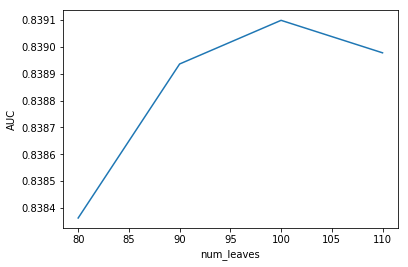

In [11]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

n_leafs = len(num_leaves_s)

x_axis = num_leaves_s
plt.plot(x_axis, test_means)
#plt.errorbar(x_axis, -test_means, yerr=test_stds,label = ' Test')
#plt.errorbar(x_axis, -train_means, yerr=train_stds,label = ' Train')
plt.xlabel( 'num_leaves' )
plt.ylabel( 'AUC' )
plt.show()

In [12]:
test_means

array([0.83836298, 0.83893595, 0.83909829, 0.83897745])

In [13]:
num_leaves_best=grid_search.best_params_['num_leaves']

In [14]:
num_leaves_best

100

In [18]:
#每个叶子最小样本
params = {'boosting_type': 'goss',
          'objective': 'binary',
          'is_unbalance':True,
          'categorical_feature': [0,1,2,4,5,6],
          'n_jobs': 2,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'num_leaves': num_leaves_best,
          'max_depth': 7,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

min_child_samples_s = range(100,130,10) 
tuned_parameters = dict( min_child_samples = min_child_samples_s)

grid_search = GridSearchCV(lg, n_jobs=2,  param_grid=tuned_parameters, cv = kfold, scoring="roc_auc", verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed: 173.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='goss', categorical_feature=[0, 1, 2, 4, 5, 6],
        class_weight=None, colsample_bytree=0.7, importance_type='split',
        is_unbalance=True, learning_rate=0.1, max_depth=7,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
      ....0, reg_lambda=0.0, silent=False,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'min_child_samples': range(100, 130, 10)},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='roc_auc', verbose=5)

In [20]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8229049048961845
{'min_child_samples': 120}


F:\Anaconada3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
F:\Anaconada3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


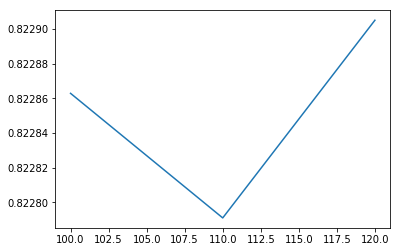

In [21]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = min_child_samples_s

plt.plot(x_axis, test_means)
#plt.errorbar(x_axis, -test_scores, yerr=test_stds ,label = ' Test')
#plt.errorbar(x_axis, -train_scores, yerr=train_stds,label =  +' Train')

plt.show()

In [23]:
bset_min_child=grid_search.best_params_['min_child_samples']

In [ ]:
#列采样数
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'is_unbalance':True,
          'categorical_feature': [0,1,2,4,5,6],
#          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'num_leaves': 100,
          'max_depth': 7,
          'min_child_samples':120
          #'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

colsample_bytree_s = [i/10.0 for i in range(5,10)]
tuned_parameters = dict( colsample_bytree = colsample_bytree_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="roc_auc", verbose=5, refit = False)
grid_search.fit(X_train , y_train)
#grid_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [9]:
#这个跑了太久没跑出来就用小数据集得到的
colsample_bytree=0.8
num_leaves_best=100
bset_min_child=120

In [10]:
#sample 这个也是跑了很久没跑完，最后跑到0.8都用了7个小时，觉得可以接受
params = {'boosting_type': 'gbdt',
          'objective': 'binary', 
          'is_unbalance':True,
          'categorical_feature': [0,1,2,4,5,6],
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'num_leaves': 100,
          'max_depth': 7,
          'min_child_samples':120,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          #'subsample': 0.7,
          'bagging_freq': 1,
          'colsample_bytree': 0.8,
         }
lg = LGBMClassifier(silent=False,  **params)

subsample_s = [i/10.0 for i in range(5,10)]
tuned_parameters = dict( subsample = subsample_s)

grid_search = GridSearchCV(lg, n_jobs=2,  param_grid=tuned_parameters, cv = kfold, scoring="roc_auc", verbose=5, refit = False)
grid_search.fit(X_train , y_train)
#grid_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 302.3min
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed: 370.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt',
        categorical_feature=[0, 1, 2, 4, 5, 6], class_weight=None,
        colsample_bytree=0.8, importance_type='split', is_unbalance=True,
        learning_rate=0.1, max_bin=127, max_depth=7, min_child_samples=120,
        min_child_we....0, reg_lambda=0.0, silent=False, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='roc_auc', verbose=5)

In [11]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.839749252401957
{'subsample': 0.9}


F:\Anaconada3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
F:\Anaconada3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


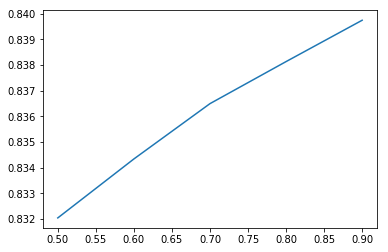

In [14]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = subsample_s

plt.plot(x_axis, test_means)
#plt.errorbar(x_axis, -test_scores, yerr=test_stds ,label = ' Test')
#plt.errorbar(x_axis, -train_scores, yerr=train_stds,label =  +' Train')

plt.show()

In [15]:
#调整学习率再来看一下最大树数目
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'is_unbalance':True,
          'categorical_feature': [0,1,2,4,5,6],
           'n_jobs': 4,
          'learning_rate': 0.01,
          #'n_estimators':n_estimators_1,
          'num_leaves': 100,
          'max_depth': 7,
          'min_child_samples':120,
          'colsample_bytree': 0.8,
          'subsample': 0.9
         }
n_estimators_2 = get_n_estimators(params , X_train , y_train, early_stopping_rounds=50)

F:\Anaconada3\lib\site-packages\lightgbm\basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


best n_estimators: 10000
best cv score: 0.8187739565591702


In [16]:
n_estimators_2

10000

In [11]:
#最后训练模型
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'is_unbalance':True,
          'categorical_feature': [0,1,2,4,5,6],
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'num_leaves': 100,
          'max_depth': 7,
          'min_child_samples':120,
          'colsample_bytree': 0.8,
          'subsample': 0.8
         }

lg = LGBMClassifier(silent=False,  **params)
lg.fit(X_train, y_train)

F:\Anaconada3\lib\site-packages\lightgbm\basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


LGBMClassifier(boosting_type='gbdt', categorical_feature=[0, 1, 2, 4, 5, 6],
        class_weight=None, colsample_bytree=0.8, importance_type='split',
        is_unbalance=True, learning_rate=0.1, max_depth=7,
        min_child_samples=120, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=3453, n_jobs=4, num_leaves=100, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [12]:
lg.best_score_

defaultdict(dict, {})

In [13]:
import pickle 

pickle.dump(lg, open("LightGBM_.pkl", 'wb'))

In [15]:
df = pd.DataFrame({"columns":list(feat_names), "importance":list(lg.feature_importances_.T)})
df = df.sort_values(by=['importance'],ascending=False)

In [16]:
df

,columns,importance
9,times_Mon,34485
6,bd,33551
5,city,24181
14,artist_name_hash_1,20092
26,composer_hash_3,12924
1,source_screen_name,12839
2,source_type,10980
36,lyricist_hash_3,10321
3,song_length,9005
10,genreid_0,6808


In [17]:
#缩小学习率后的模型
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'is_unbalance':True,
          'categorical_feature': [0,1,2,4,5,6],
          'n_jobs': 4,
          'learning_rate': 0.01,
          'n_estimators':n_estimators_2,
          'num_leaves': 100,
          'max_depth': 7,
          'min_child_samples':120,
          'colsample_bytree': 0.8,
          'subsample': 0.9
         }

lg2 = LGBMClassifier(silent=False,  **params)
lg2.fit(X_train, y_train)

F:\Anaconada3\lib\site-packages\lightgbm\basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


LGBMClassifier(boosting_type='gbdt', categorical_feature=[0, 1, 2, 4, 5, 6],
        class_weight=None, colsample_bytree=0.8, importance_type='split',
        is_unbalance=True, learning_rate=0.01, max_depth=7,
        min_child_samples=120, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=10000, n_jobs=4, num_leaves=100, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

In [18]:
import pickle 

pickle.dump(lg2, open("LightGBM_.pkl2", 'wb'))

In [19]:
df2 = pd.DataFrame({"columns":list(feat_names), "importance":list(lg2.feature_importances_.T)})
df2 = df2.sort_values(by=['importance'],ascending=False)

In [20]:
df2

,columns,importance
6,bd,125709
9,times_Mon,109256
5,city,88087
14,artist_name_hash_1,58054
1,source_screen_name,43490
2,source_type,37077
26,composer_hash_3,36277
36,lyricist_hash_3,29091
3,song_length,23480
10,genreid_0,22429
